# Medical Image Processing

## Introduction

In this notebook we will discuss some examples of typical image processing that is done on medical images. We will focus on teh following examples:

* Histograms used as a contrast enhancement tool (adaptive equalization)
* Filtering
* Segmentation

## Image Enhancement - Histogram Equalization

The histogram of an image is a concept that was introduced in the last notebook. We can count the number of pixels at each of the values or bins available depending on the bits. With an N-bit encoded image we have $2^N$ bins available. The histogram is therefore a distribution of discrete intensity levels in the range [0,$2^N-1$]. And this distribution is a discrete function that associates each intensity level to the the number of pixel with this intensity.

**Histogram equalization** was discussed before and it is a method to process the image to adjust the contrast by modifying the intensity distribution and making it linear or "flat" (from the histogram perspective). The result is a linear trend to the cumulative probability function associated to the image. This is based on the cumulative probability function (cdf) of this histogram and it was part of a *challenge* to make the mathematical definition. As a general rule this technique works well in images that are *all dark* or *all white* and in particular if the distribution is close to a gaussian centered anywhere. It does not work too well when the image has just a large amount of dark or white pixels concentrated in a region.

**Adaptive histogram equalization (AHE)** is an image processing technique also used to adjust contrast in images. It differs from ordinary histogram equalization in the respect that the adaptive method computes several histograms, each corresponding to a distinct section of the image, and uses them to redistribute the lightness values of the image. 

**Contrast limited adaptive histogram equalization (CLAHE)** is based in the same principle as AHE but does not tend to amplify noise dince the amplification is limited.

We will implement here a CLAHE algorith and apply it to the abdomen image that we worked with in the last notebook.

In [1]:
!pip install pydicom

  Using cached pydicom-2.2.2-py3-none-any.whl (2.0 MB)


/tmp/ipykernel_68/2768348982.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))


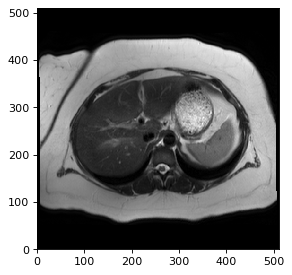

In [5]:
# As usual we will have the magic command for figures inline, but you can use interactive nbagg if you prefer
%matplotlib inline

# And we will start by importing the numerical and ploting packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# As well as the DICOM package
import pydicom

# Get file
RefDs = pydicom.read_file('Source Files/IM_0028.dcm')
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
# Then initialize in zeros an array
ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
# Finally we had already read the file and we have the image information in the pixel_array (final field)
ArrayDicom[:,:]=RefDs.pixel_array
# Some rendering tools here to set the size of that image to a specific value dpi and equal axis or square image as well
# as work with grayscale
fig=plt.figure(figsize=(4, 4), dpi= 80, facecolor='w', edgecolor='b')
plt.axes().set_aspect('equal') #this makes the image square
plt.set_cmap(plt.gray()) #grayscale
# Colormesh will require a horizontal and vertical axes
Rows=np.arange(RefDs.Rows)
Columns=np.arange(RefDs.Columns)
# This is the actual rendering
plt.pcolormesh(Rows, Columns, np.flipud(ArrayDicom[:, :]))
NormIm=1.0*ArrayDicom
NormIm=NormIm/np.max(ArrayDicom)
Im=NormIm*(pow(2,12)-1)  #original encoding at 12 bits
Im=Im.astype(int)

NN=RefDs.Rows  #keep the size of the image in NN

Text(0.5, 1.0, 'Original 12-bit Image')

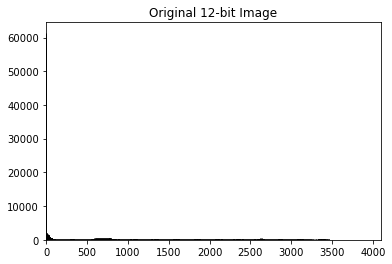

In [6]:
# This uses numpy to generate a histogram
hist,bins = np.histogram(Im.flatten(),4096,[0,4096])

# And we plot the histogram here for the original 12 bit image
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.xlim([0,4096])
plt.title('Original 12-bit Image')

### Histogram Equalization

Using the code in Notebook 2 we will perform the histogram equalization

(0.0, 4096.0)

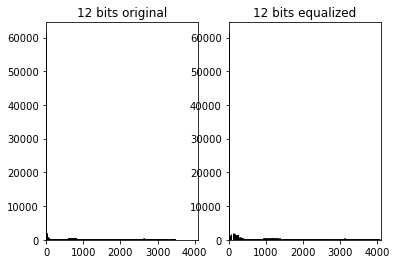

In [7]:
cdf = hist.cumsum()         

cdf = (cdf - cdf.min())*4096/(cdf.max()-cdf.min())         
cdf = np.ma.filled(cdf,0).astype('uint16')                 

Im2 = cdf[Im]       

# And we plot the histogram before and after equalization
plt.subplot(121)
plt.hist(Im.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.title('12 bits original')
plt.xlim([0,4096])
plt.subplot(122)
plt.hist(Im2.flatten(), 4096, [0,4096], fc='k', ec='k')
plt.title('12 bits equalized')
plt.xlim([0,4096])

An the images for the original and equalized histograms

/tmp/ipykernel_68/320162832.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Rows, Columns, np.flipud(Im[:, :]))
/tmp/ipykernel_68/320162832.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Rows, Columns, np.flipud(Im2[:, :]))


(0.0, 511.0, 0.0, 511.0)

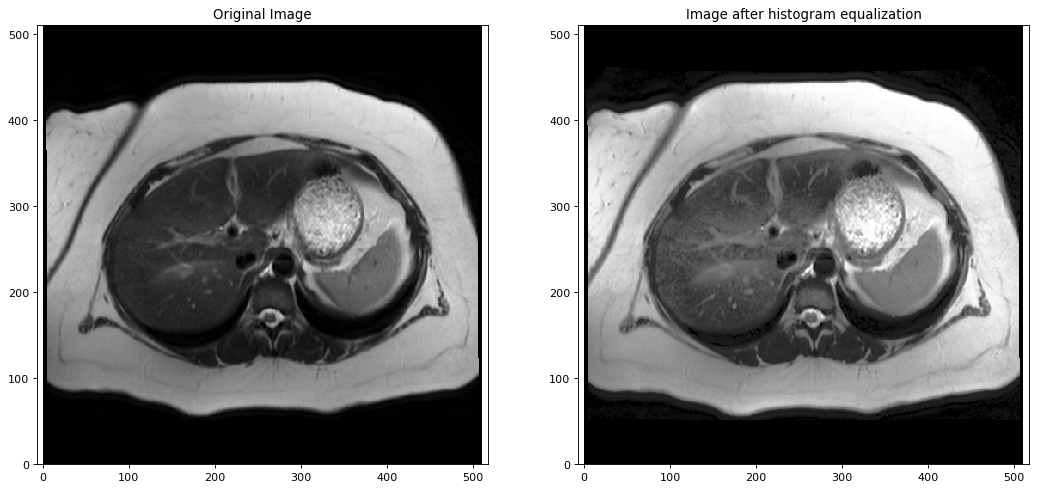

In [8]:
fig=plt.figure(figsize=(16, 16), dpi= 80, facecolor='w', edgecolor='b')
plt.subplot(221)
plt.pcolormesh(Rows, Columns, np.flipud(Im[:, :]))
plt.title('Original Image')
plt.axis('equal') #this makes the image square
plt.subplot(222)
plt.pcolormesh(Rows, Columns, np.flipud(Im2[:, :]))
plt.title('Image after histogram equalization')
plt.axis('equal') #this makes the image square

### Histogram adaptive equalization

The standard procedure for adaptive equalization is subdivide the image in 1/8 and run the histogram equalization on each segment. We will use a function to make this.

(0.0, 512.0, 0.0, 512.0)

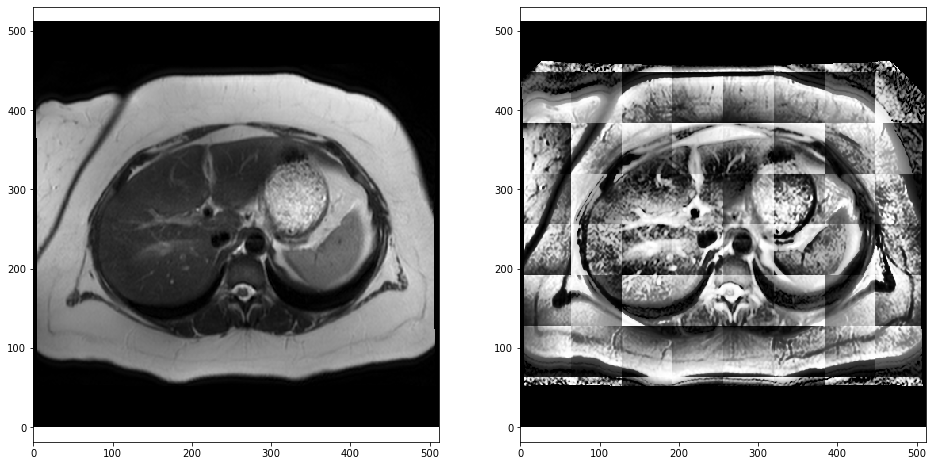

In [9]:
# Function to do histogram equalization of an image (or subimage)
def OutIm(ImSeg,Bits):
    hist,bins = np.histogram(ImSeg.flatten(),pow(2,Bits),[0,pow(2,Bits)])
    cdf = hist.cumsum()         
    cdf = (cdf - cdf.min())*pow(2,Bits)/(cdf.max()-cdf.min())         
    cdf = np.ma.filled(cdf,0).astype('uint16')      
    Im2 = cdf[ImSeg] 
    return Im2

# This will divide the image in pieces of size WNxWN
WN=64 #size of the sub-image
N=int(NN/WN)  #total of sub-images

Segments=np.zeros((N*N,int(NN/N),int(NN/N)))
SegmentsV=np.split(Im,N)
ixT=0
for ix1 in np.arange(0,N):
    SegmentsH=np.split(SegmentsV[ix1],N,1)
    for ix2 in np.arange(0,N):
        Segments[ixT]=SegmentsH[ix2]
        ixT+=1

# And we process all the parts
SegmentsProcessed=np.zeros((N*N,int(NN/N),int(NN/N)))
ImageSegment=np.zeros((int(NN/N),int(NN/N)))
for ix in np.arange(0,N*N):
    ImageSegment=Segments[ix].astype('int')
    SegmentsProcessed[ix]=OutIm(ImageSegment,12)

# To finally reform the image
Total=np.zeros((NN,NN))
TotalH=np.zeros((N,int(NN/N),NN))
for ixF in np.arange(0,N):
    TotalH[ixF]=np.concatenate(SegmentsProcessed[ixF*N:ixF*N+N],1)
Total=np.concatenate(TotalH,0)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(Im[:,:]))
plt.axis('equal') #this makes the image square
plt.subplot(122)
plt.pcolormesh(np.flipud(Total[:,:]))
plt.axis('equal') #this makes the image square

### Activity 1 - Analyze this *erroneous* adaptive histogram equalization and discuss: 
#### 1) What happens to sub-images that have very low values (close to noise)
#### 2) Why does the separate processing per sub-image is not the correct way to apply histogram equalization?
#### 3) Infer from the code below the *correct* way to perform adaptive histogram equalization and describe how this was corrected

**Answer the questions here**



/tmp/ipykernel_68/3558259184.py:5: RuntimeWarning: invalid value encountered in true_divide
  cdf = (cdf - cdf.min())*pow(2,Bits)/(cdf.max()-cdf.min())


(0.0, 512.0, 0.0, 512.0)

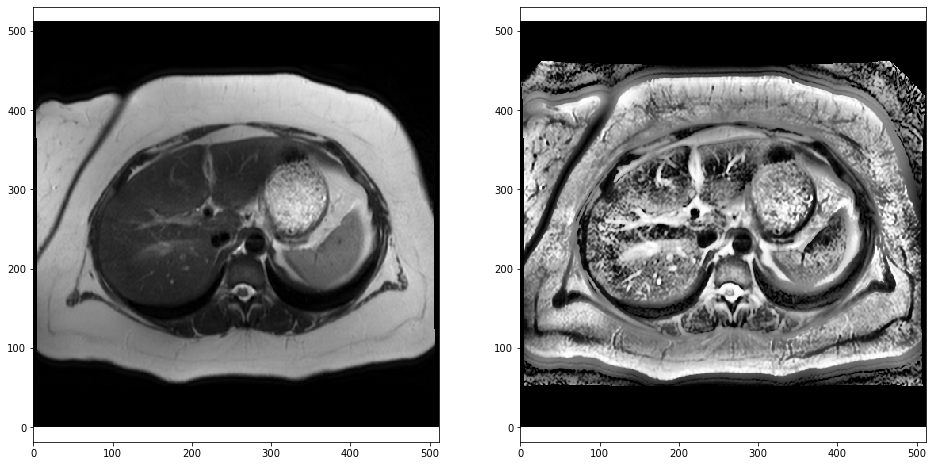

In [10]:
# Function to do histogram equalization of an image (or subimage) 
def OutIm(ImSeg,Bits):
    hist,bins = np.histogram(ImSeg.flatten(),pow(2,Bits),[0,pow(2,Bits)])
    cdf = hist.cumsum()         
    cdf = (cdf - cdf.min())*pow(2,Bits)/(cdf.max()-cdf.min())         
    cdf = np.ma.filled(cdf,0).astype('uint16')      
    ImO = cdf[ImSeg] 
    return ImO

# This will divide the image in pieces of size WNxWN
WN=64 #size of the sub-image

Im2=np.zeros((NN,NN))                                                #?  
ExpandedIm=np.zeros((NN+WN,NN+WN))                                   #?  
ExpandedIm=ExpandedIm.astype(int)                                    #?  
np.copyto(ExpandedIm[int(WN/2):NN+int(WN/2),int(WN/2):NN+int(WN/2)],Im,casting='no')     #?  

SegmentW=np.zeros((WN,WN))                                           #?  
for ixW2 in np.arange(0,NN):                                         #?  
    for ixW1 in np.arange(0,NN):                                     #?  
        SegmentW=ExpandedIm[ixW1:ixW1+WN,ixW2:ixW2+WN]               #?  
        SegmentW=OutIm(SegmentW,12)                                  #?  
        Im2[ixW1,ixW2]=SegmentW[int(WN/2),int(WN/2)]                 #?  

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(Im[:,:]))
plt.axis('equal') #this makes the image square
plt.subplot(122)
plt.pcolormesh(np.flipud(Im2[:,:]))
plt.axis('equal') #this makes the image square

### Activity 2 - Analyze the code cell above and add comments where #? is present to explain how this algorithm works and answer:
#### 1) Describe briefly in your own words how does the algorithm work
#### 2) What is the reason for the black area around the abdomen to appear now with high intensity (shadow noise)? 
#### 3) How could we control this noise in the image?

** Answer the questions here**



## Image Filtering

Images are filtered for many different reasons. As we discussed previously, we know that the fast changes of an image, related to the edges, are in the high frequencies of an image. It could be therefore that if we wanted to smooth an image, applying a low-pass filter could help with this process. On the other hand, if we wanted to sharpen an image by enhancing the edges, eliminating the low frequencies with a high-pass filter could be useful.

Here we will discuss two different imaging filtering techniques that are commonly used in medical images:

* Median Filter commonly used to remove *salt and pepper* noise or *speckle* noise
* High Pass Filter commonly used to extract edges

### Median Filter
 
This is a nonlinear digital filter often used to remove noise from an image. It is a typical pre-processing step that may be applied before rendering an image or used to improve the results of later processing (for example, segmentation of an image). Median filtering is very useful since it usually doesn not affect the edges while still removing noise.

Median filtering is done by replacing each pixel in the image with the median of neighboring pixels. We usually define a "slidding window" over the entire image. This is usually a square 2D box but more complex patterns may also be used. Because we are substituing a pixel with its neighbours, we define this filter as an odd NxN box so the pixel of interest is at the centre of this box.

In the following code we will use the **medfilt** function in **scipy.signal** to perform this filtering.

Text(0.5, 1.0, 'Image after AHE median filtered')

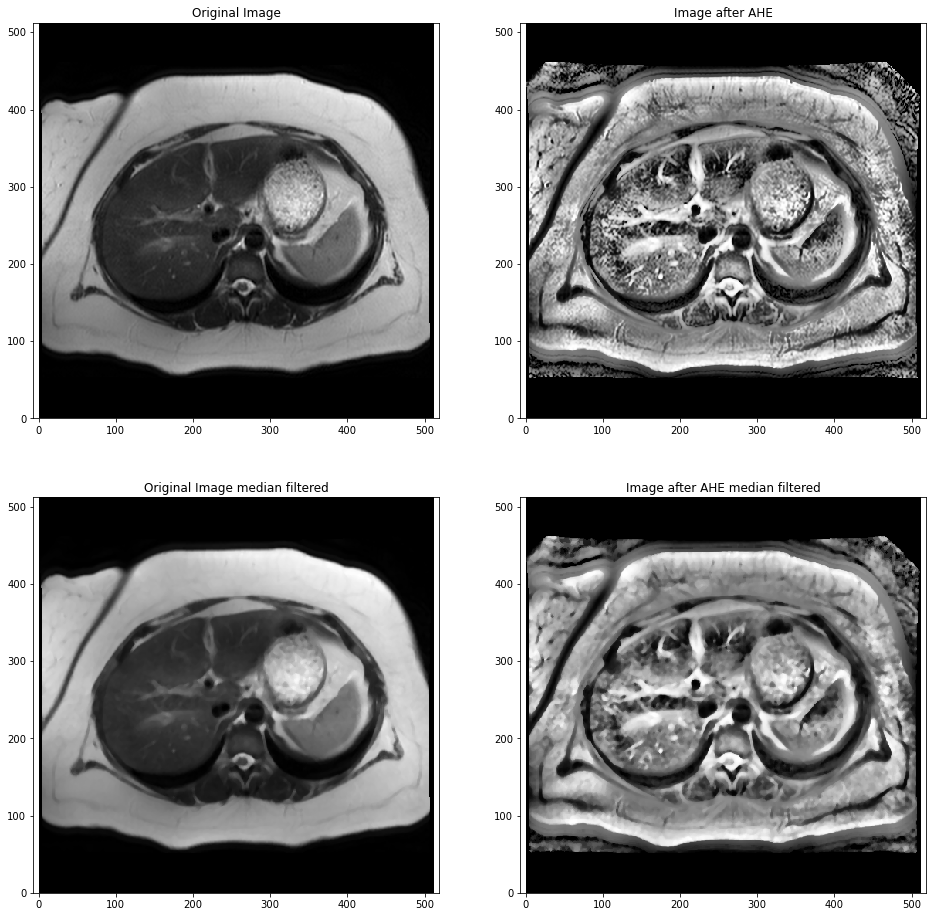

In [11]:
from scipy.signal import medfilt

ImageF=medfilt(Im,5)
ImageAHEF=medfilt(Im2,5)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.pcolormesh(np.flipud(Im[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(Im2[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Image after AHE')
plt.subplot(223)
plt.pcolormesh(np.flipud(ImageF[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Original Image median filtered')
plt.subplot(224)
plt.pcolormesh(np.flipud(ImageAHEF[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Image after AHE median filtered')

We can observe from the filtered images how some of the noise that was introduced by the enhancement performed with the AHE is indeed reduced or smoothed by the median filter. There is however a clear smoothing of the image which may modify the interpretation of the image and should be considered.

### Activity 3 - Add a cell code below where the parameters on the median filter are different and discuss the effect of changing those values. What happens if you define an even number for the filter, why?




In [12]:
# Add your code for Activity 3 
# HERE



### High pass filter

A high pass filter will be usually performed when we want to extract the edges on an image. One of the most widely used high pass filters in medical imaging is the **Sobel** filter. The Sobel filter is used in medical image processing for edge detection since it creates an image emphasising edges. The Sobel filter is based on isotropic image gradient operators. It is based on differentiation where each pixel of the image is replaced with the norm of its own gradient vector. This is obtained by computing the convolution of each pixel in the image by a gradient kernel for each of the directions in the image, and then obtaining the norm of that result.

In the following code we use directly the sobel operator implemented in **scipy** to filter the image before and after AHE and we can observe the extraction of the edges.

Text(0.5, 1.0, 'Image after AHE Sobel filtered')

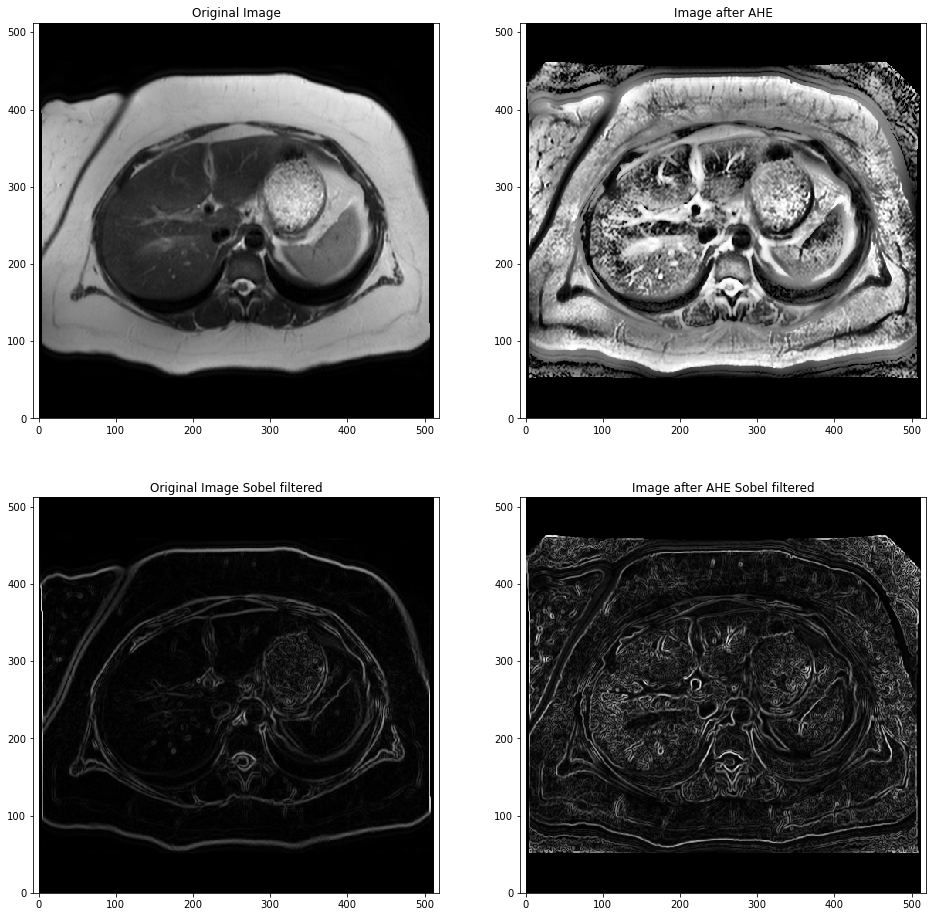

In [13]:
from scipy import ndimage

ImageSobelFx=ndimage.sobel(Im,axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(Im,axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)

ImageAHESobelFx=ndimage.sobel(Im2,axis=0, mode='constant')
ImageAHESobelFy=ndimage.sobel(Im2,axis=1, mode='constant')
ImageAHESobelF=np.hypot(ImageAHESobelFx, ImageAHESobelFy)

plt.figure(figsize=(16, 16))
plt.subplot(221)
plt.pcolormesh(np.flipud(Im[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Original Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(Im2[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Image after AHE')
plt.subplot(223)
plt.pcolormesh(np.flipud(ImageSobelF[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Original Image Sobel filtered')
plt.subplot(224)
plt.pcolormesh(np.flipud(ImageAHESobelF[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Image after AHE Sobel filtered')

We can now clearly observe the advantages of using AHE if we were to better define the edges and details within the liver in the image above.

### Activity 4 - Add code bellow to perform an edge detection using Sobel on the image after median filtering. 

In [14]:
# Add your code for Activity 4
# HERE



### Activity 5 - Compare the images obtained with your code after median filter and those provided before. Discuss the differences you observe and why are those appearing.

**Add your discussion here**



### Image Segmentation

Image segmentation is the separation of objects within an image. An image can be then divided into multiple segments (sets of pixels). There are many uses to image segmentation, the most common being the definition of automatic regions of interest in a medical image, for instance, the automatic detection of an organ. The usual result of a segmentation is a mask that can have just two values (0 and 1) for what is "in" or "out" of that area of interest; or a more complex set of integer values each one of them defining a sub-region (1,2,3 for three detected sub-regions). Image segmentation can be then defined as *the process of assigning a label to every pixel in an image such that pixels with the same label are part of the same region*.

In this example we will segment our image into three regions simply dividing them by intensity values. The dark pixels will be in a region called **1**, the intermediate pixels will be in **2** and the lighter pixels will be in **3**. 

We can very simply perform this segmentation using the values in the image.

Text(0.5, 1.0, 'Segmented Mask Image after AHE')

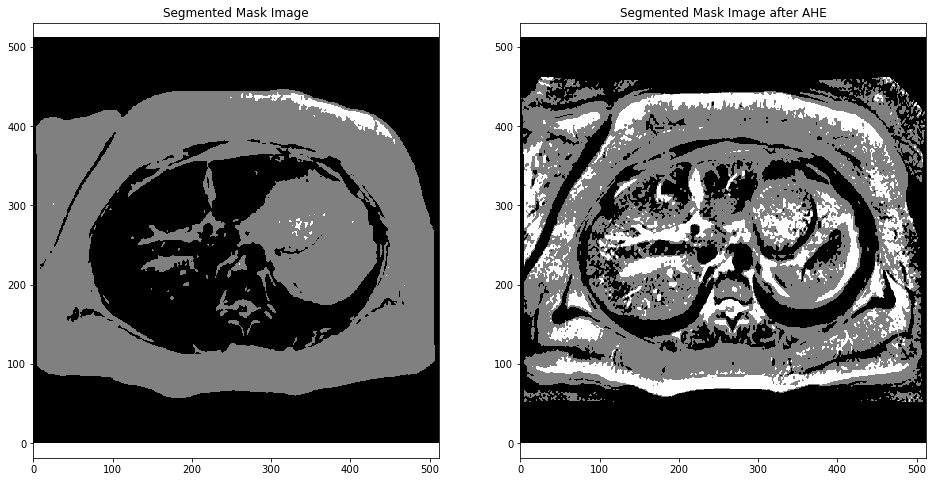

In [15]:
markers = np.zeros_like(Im)
markers[Im <= 1050] = 1          
markers[Im > 1050] = 2
markers[Im > 3500] = 3

markersAHE = np.zeros_like(Im2)
markersAHE[Im2 <= 1500] = 1     #note that I used a different values after AHE so I still have 3 regions (histogram!)
markersAHE[Im2 > 1500] = 2
markersAHE[Im2 > 3000] = 3

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.pcolormesh(np.flipud(markers[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask Image')
plt.subplot(122)
plt.pcolormesh(np.flipud(markersAHE[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Segmented Mask Image after AHE')

This simple segmentation is effective but we could also use more sofisticated algorithms such as **watershed**. Watershed segmentation refers to a geological watershed, or drainage, that separates adjacent regions. The watershed transformation treats the image like a topographic map, with the brightness of each point representing its height, and finds the lines that run along the tops of ridges. It therefore requires a map that can be provided by the resulting edge detection that a **Sobel** operator provides.

To better understand how this works, we will first plot the *elevation* map that the Sobel operator provided for the original image.

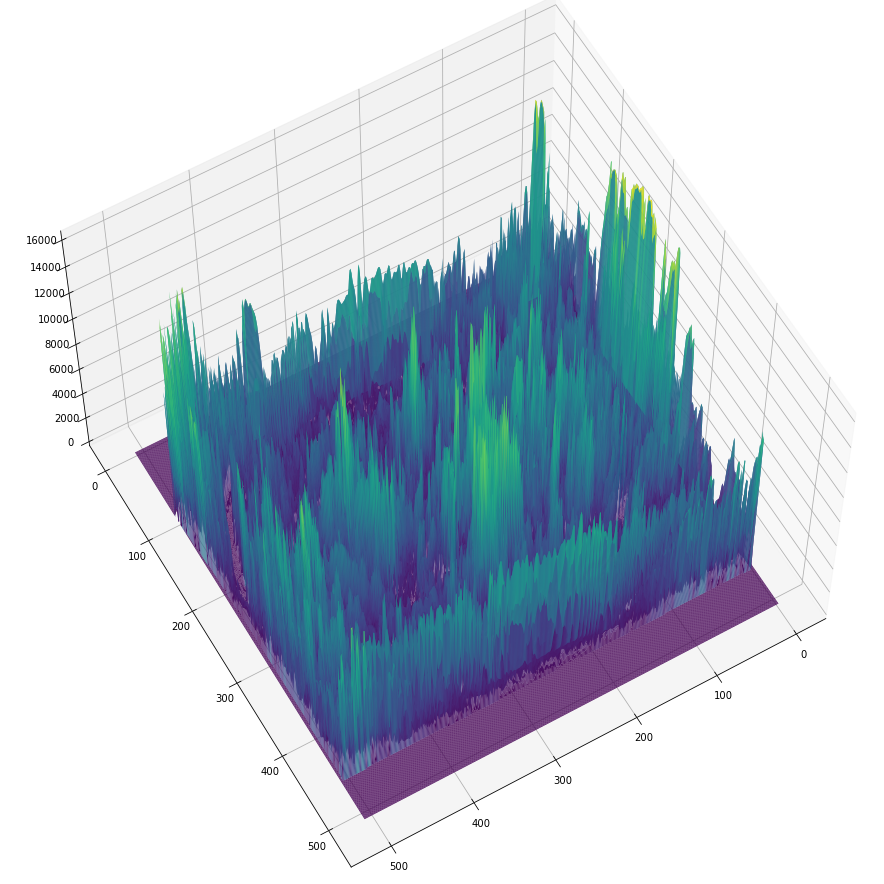

In [16]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(16, 16))
X, Y = np.meshgrid(Rows, Columns)
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,ImageAHESobelF,rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.view_init(60, 60)

We can see that the edges are actually defined by Sobel as elevations and they are not all *created* equal. We can then use the watershed algorith where will use these elevations to perform the segmentation. 

Text(0.5, 1.0, 'Watershed Segmented Mask Image after AHE')

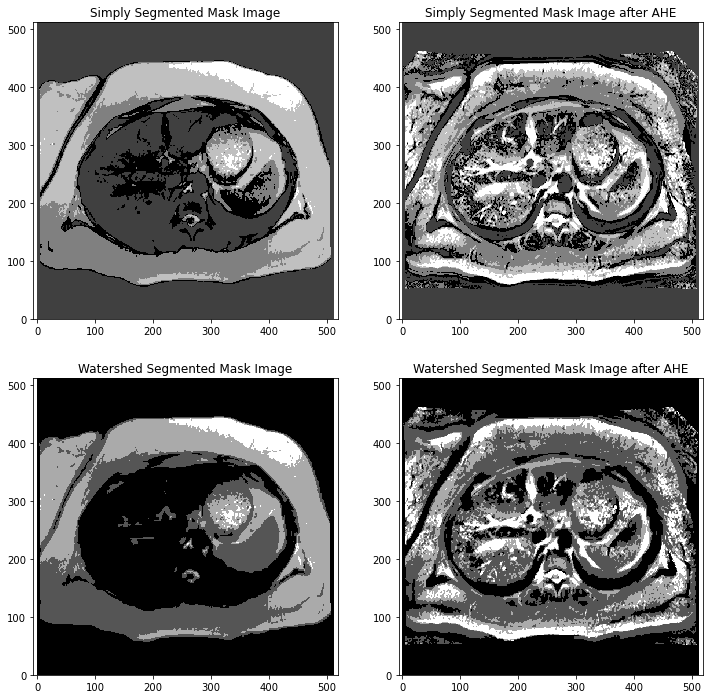

In [17]:
# Sobel filtering (not required if you ran the last cells)

ImageSobelFx=ndimage.sobel(Im,axis=0, mode='constant')
ImageSobelFy=ndimage.sobel(Im,axis=1, mode='constant')
ImageSobelF=np.hypot(ImageSobelFx, ImageSobelFy)

ImageAHESobelFx=ndimage.sobel(Im2,axis=0, mode='constant')
ImageAHESobelFy=ndimage.sobel(Im2,axis=1, mode='constant')
ImageAHESobelF=np.hypot(ImageAHESobelFx, ImageAHESobelFy)

# Using 4 levels for this example
markers = np.zeros_like(Im)
markers[Im <= 4096/5] = 1
markers[Im > 4096*2/5] = 2
markers[Im > 4096*3/5] = 3
markers[Im > 4096*4/5] = 4

markersAHE = np.zeros_like(Im2)
markersAHE[Im2 <= 4096/5] = 1
markersAHE[Im2 > 4096*2/5] = 2
markersAHE[Im2 > 4096*3/5] = 3
markersAHE[Im2 > 4096*4/5] = 4

segIm = ndimage.watershed_ift(ImageSobelF.astype('uint16'),markers.astype(int))
segIm2 = ndimage.watershed_ift(ImageAHESobelF.astype('uint16'),markersAHE.astype(int))

plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.pcolormesh(np.flipud(markers[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Simply Segmented Mask Image')
plt.subplot(222)
plt.pcolormesh(np.flipud(markersAHE[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Simply Segmented Mask Image after AHE')
plt.subplot(223)
plt.pcolormesh(np.flipud(segIm[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Watershed Segmented Mask Image')
plt.subplot(224)
plt.pcolormesh(np.flipud(segIm2[:,:]))
plt.axis('equal') #this makes the image square
plt.title('Watershed Segmented Mask Image after AHE')

Where we can see that watershed tends to ignore some of the regions as the edges are not so high and therefore still considered the same *basin* of the flood caused by watershed.

## Summary

In this example we:

* Showed how adaptive histogram equalization is implemented used to enhance an image, as well as possible mistakes and effects that are observed with this enhancement technique
* Showed the effect of two different filtering techniques on images
* Investigated one technique used for image segmentation

Comments and corrections welcome!

## Assignment 3

* Complete the 5 Activities in the notebook and upload your notebook to your GitHub repository.
* Remember you should have given permissions to this **private** repository to your instructor.
* Please note you should upload all your code in the repository with those permissions, do not give permissions every time for new repositories.
* Submit on D2L the PDF of your notebook where the results of these activities can be seen. The backup PDF accounts for 10% of your mark. Note that full marks are only given if the code is on your repository and runs, but you can get partial marks from this PDF output if the code fails to run or is not accessible at the time of grading. No marks will be given if the date on GitHub is after the deadline.
* The following challenges **are for bonus points** and you can submit them later (up until the final exam date) 

## Challenge \#6 - Contrast Limited AHE

Implement below a CLAHE out of the code provided for AHE using interactive sliding tools for the minimum and maximum contrast to be clipped from the image.

In [ ]:
# Write your challenge 6 code here

## Challenge # 7 - Segmentation
Investigate and implement a different segmentation technique. You should briefly explain the principles on which this technique is based and analyse the result you obtain compared with Sobel and grey-level.

In [ ]:
# Write your challenge 7 code here

References
---------------

* Tinku Acharya and Ajoy K. Ray, *Image Processing - Principles and Applications*. Wiley InterScience, 2006.
* https://docs.scipy.org